# Understanding the Dataset and Question

## General information about Enron
Enron Corporation was an American energy, commodities, and services company and in 2000 was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy as a result of fraudulent accounting practices. 

## Our database
The Enron Corpus is a large database of over 600,000 emails generated by 158 employees of the Enron Corporation and acquired by the Federal Energy Regulatory Commission during its investigation after the company's collapse. 
So basically as a result of this federal investigations a significant amount of typically confidential information entered into the public record, including emails and detailed financial data for top executives.

## Goal of our project
During this project our target is to build a person of interest identifier based on the Enron email and financial data. In order to identify Persons of Interest(POI) we are going to use Machine Learning, so engineer the features, pick and tune an algorithms, and to test and evaluate the created identifier.

## Data Exploration 
we've a combined database with financial and email data made public as a result of the Enron scandal , where features in the data fall into three major types described below.

financial features (all units are in US dollars): 
* salary
* deferral_payments
* total_payments
* loan_advances 
* bonus
* restricted_stock_deferred
* deferred_income 
* total_stock_value
* expenses
* exercised_stock_options
* other
* long_term_incentive
* restricted_stock
* director_fees 

email features: 
* to_messages
* email_address
* from_poi_to_this_person
* from_messages
* from_this_person_to_poi
* shared_receipt_with_poi

POI label:
* poi


In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import pprint as pp
import pickle
import sys
sys.path.append("../tools/")

In [18]:
# Machine Learning packages
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_score, recall_score, accuracy_score

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import tester

In [19]:
# Seaborn plotting
import matplotlib.pyplot as plt
import seaborn as sns
p = sns.color_palette()

In [20]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Read into dataframe, the data_dict is converted to pandas DataFrame for easier calculations, and then converted back to dictionary.
df = pd.DataFrame.from_dict(data_dict,orient='index')
df = df.replace('NaN',np.nan)

In [21]:
# Total number of data points
df.shape

(146, 21)

So without handling our outliers we have 146 rows and 21 columns - features (listed above) in our database. Let's count our Persons of Interest and also list them. There are 18 POIs in the database, which is quite small as sample, so we shall definitely check the missing values before selecting our features. 

In [22]:
# Number of POIs and non-POIs
pd.value_counts(df['poi'].values, sort=False)

False    128
True      18
dtype: int64

In [23]:
# List of POIs
df[(df.poi > 0)][['poi']]

,poi
BELDEN TIMOTHY N,True
BOWEN JR RAYMOND M,True
CALGER CHRISTOPHER F,True
CAUSEY RICHARD A,True
COLWELL WESLEY,True
DELAINEY DAVID W,True
FASTOW ANDREW S,True
GLISAN JR BEN F,True
HANNON KEVIN P,True
HIRKO JOSEPH,True


In [24]:
# Allocation of POIs across features
df.groupby('poi').count()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
poi,,,,,,,,,,,,,,,,,,,,
False,78,72,34,107,90,66,93,72,18,108,77,3,72,75,72,17,38,54,93,72
True,17,14,5,18,12,16,17,14,0,18,18,1,14,18,14,0,11,12,18,14


From this table above we could clearly see that there surely must be some missing data, which in some cases is normal (like not everyone receives director fees or loan advances). As we are mainly focusing on our 18 POIs it is important to note that in which features we have more than half of the data missing in case of our POIs:
* deferral_payments
* restricted_stock_deferred
* loan_advances
* director_fees
These are features we shall remove later from our list of features and analysis.
To get an overall view let's list all the missing data per feature.
For the e-mailing data we have for all 5 features 86 person data available.

In [25]:
df.isnull().sum().sort_values()

poi                            0
total_stock_value             20
total_payments                21
email_address                 35
restricted_stock              36
exercised_stock_options       44
salary                        51
expenses                      51
other                         53
from_messages                 60
from_this_person_to_poi       60
to_messages                   60
shared_receipt_with_poi       60
from_poi_to_this_person       60
bonus                         64
long_term_incentive           80
deferred_income               97
deferral_payments            107
restricted_stock_deferred    128
director_fees                129
loan_advances                142
dtype: int64

So we have lot's of missing values, which is something we shall definitely keep in mind during our analysis. Good news is that we don't have missing data in the POI category.

## Outlier Investigation 

During our analysis in the outlier lesson we had found an outlier with visualization of the bonuses and salaries and also identified it from the available original financial data source. As a reminder let's visualize this outlier again.

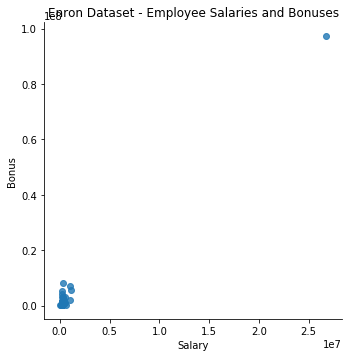

In [26]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False);
plt.title('Enron Dataset - Employee Salaries and Bonuses');
plt.xlabel('Salary');
plt.ylabel('Bonus');
plt.show()

As it turned out it was the "TOTAL" field in our dictionary. With checking the original financial data right above the "TOTAL" field another outlier pops up: "THE TRAVEL AGENCY IN THE PARK". As according to the footnotes in the document we can clearly say it is irrelevant for our analysis I've decided to remove it. So let's remove these outliers and plot again our data. 

In [27]:
# Remove outliers
identified_outliers = ["TOTAL", "THE TRAVEL AGENCY IN THE PARK"]

for outlier in identified_outliers:
    data_dict.pop(outlier)

# Recreate dataframe
df = pd.DataFrame.from_dict(data_dict,orient='index')
df = df.replace('NaN',np.nan)

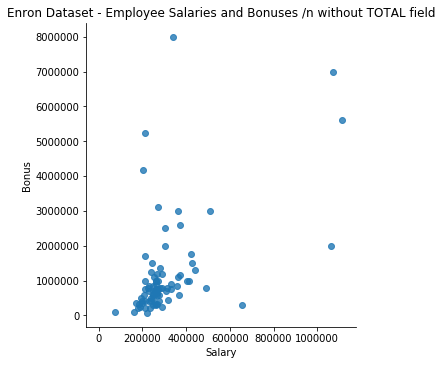

In [28]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False);
plt.title('Enron Dataset - Employee Salaries and Bonuses /n without TOTAL field');
plt.xlabel('Salary');
plt.ylabel('Bonus');
plt.show()

We could clearly see some more potential outliers (4 clear ones), let's idenify them. Just check those points where the salary is higher than 500 000$ or the bonus is higher than 5 000 000$.

In [29]:
# Potential outliers
df[(df.salary > 500000) | (df.bonus > 5000000)][['poi','bonus','salary']]

,poi,bonus,salary
BELDEN TIMOTHY N,True,5249999.0,213999.0
FREVERT MARK A,False,2000000.0,1060932.0
LAVORATO JOHN J,False,8000000.0,339288.0
LAY KENNETH L,True,7000000.0,1072321.0
PICKERING MARK R,False,300000.0,655037.0
SKILLING JEFFREY K,True,5600000.0,1111258.0
WHALLEY LAWRENCE G,False,3000000.0,510364.0


At first sight I would say that we shall keep this points as they look like valid data points.

Above we have seen some outliers for the financial data, but let's shortly check our e-mail data. Below a plot about the incoming and outgoing e-mails.

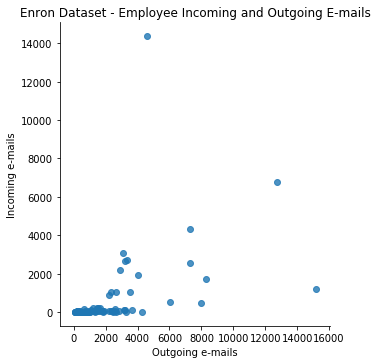

In [30]:
sns.lmplot('to_messages', 'from_messages', 
           data=df, 
           fit_reg=False);
plt.title('Enron Dataset - Employee Incoming and Outgoing E-mails');
plt.xlabel('Outgoing e-mails');
plt.ylabel('Incoming e-mails');
plt.show()

Here we also can some outliers, so let's identify them:

In [31]:
# Potential outliers
df[(df.to_messages > 5000) | (df.from_messages > 14000)][['poi','from_messages','to_messages']]

,poi,from_messages,to_messages
BECK SALLY W,False,4343.0,7315.0
BELDEN TIMOTHY N,True,484.0,7991.0
KAMINSKI WINCENTY J,False,14368.0,4607.0
KEAN STEVEN J,False,6759.0,12754.0
KITCHEN LOUISE,False,1728.0,8305.0
LAVORATO JOHN J,False,2585.0,7259.0
SHAPIRO RICHARD S,False,1215.0,15149.0
WHALLEY LAWRENCE G,False,556.0,6019.0


At this point of the analysis I would say I won't consider these points as outliers as we don't have any further information, but in the later analysis it should be kept in mind.

# Feature Engineering and Selection
Above in the dataset analysis we found 4 features where in case of the POIs more than half of the data were missing, so I'm going to take these out from my features_list: deferral_payments, restricted_stock_deferred, loan_advances and director_fees. The email_address feature has no predictive value as it is text-based, so I'm going to leave it out. In this way altogether we have 16 features left.

In [32]:
features_list = [
        'poi',
        'bonus',
        'deferred_income',
        'exercised_stock_options',
        'expenses',
        'long_term_incentive',
        'other',
        'restricted_stock',
        'salary',
        'total_payments',
        'total_stock_value',
        'from_messages',
        'from_poi_to_this_person',
        'from_this_person_to_poi',
        'shared_receipt_with_poi',
        'to_messages'
]

## Feature Engineering
First I have created a total benefits feature with adding up all the financial features.

During the feature engineering process I had two approaches. First was that I assume that those employees who were deeply involved in the fraud focused to be paid as soon as possible. The second approach is that we could easily create more informative new features with the usage of fractions instead of raw counts. 

Here a short explanation of the above mentioned first approach. In the Enron case I think that those employees who knew about the fraudulent accounting practices would like to get out as much money as fast as they could, while the non-involved employees were likely to believe in longer term motivations. So with hthis logic a possible way to start feature selection is to split our financial features on a short- and a long-term basis. 

Short-term financial features:
* salary
* expenses
* bonus 

Long-term financial features:
* long_term_incentive
* deferred_income
* exercised_stock_options
* restricted_stock
* total_stock_value

(As bonus is annual it could also be in the long-term category, but I've decided to put it into the short term category as the other long-term ones rather have 3-5 years periods.)
Of course I have to say that the problem with this logic could be that most of the employees doesn't have direct impact on their financial rewarding system, but in this case I assume that those employees who were deep involved in the fraud had some negotiation basics.

Based on this approach I've created two features to see what percent of the total payments comes from short and long term:
* fraction_short_term: (salary + bonus + expenses) / total_payments
* fraction_long_term: (long_term_incentive + deferred_income) / total_payments
Of course in an ideal world it would add up to one, but as we have removed some features, it won't be like this in our case.

As I mentioned above I had a second approach with easily creating fraction-based features, so we can see how much of the total compensation of an employee comes from salary or a long term incentive. Features created:
* fraction_salary
* fraction_bonus
* fraction_long_term_incentive
* fraction_deferred_income
* fraction_total_stock

With a similar logic we could define based on our e-mail data that how frequently a person communicates with a POIs, so sends e-mails to POI from the total number of emails sended or receives e-mails from POIs from the total number of e-mails received. Here the features created:
* fraction_to_poi
* fraction_from_poi


In [33]:
df['total_benefits'] = df['total_payments'] + df['total_stock_value']
df['fraction_short_term'] = (df['salary'] + df['bonus'] + df['expenses']) / df['total_payments']
df['fraction_long_term'] = (df['long_term_incentive'] + df['deferred_income']) / df['total_payments']
df['fraction_salary'] = df['salary']/df['total_payments']
df['fraction_bonus'] = df['bonus']/df['total_payments']
df['fraction_long_term_incentive'] = df['salary']/df['long_term_incentive']
df['fraction_deferred_income'] = df['salary']/df['deferred_income']
df['fraction_total_stock'] = df['total_stock_value']/df['total_payments']
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
df['fraction_from_poi'] = df['from_poi_to_this_person']/df['from_messages']

In [34]:
df.head(5)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,total_benefits,fraction_short_term,fraction_long_term,fraction_salary,fraction_bonus,fraction_long_term_incentive,fraction_deferred_income,fraction_total_stock,fraction_to_poi,fraction_from_poi
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,6213983.0,0.979124,-0.619085,0.045035,0.930997,0.662571,-0.065547,0.385676,0.022398,0.021412
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,440283.0,NaN,NaN,NaN,NaN,NaN,NaN,1.412959,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,6159684.0,NaN,NaN,0.000521,NaN,NaN,-0.093456,5.723100,0.000000,1.344828
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,16257601.0,0.262373,0.035497,0.047406,0.212980,0.168407,-0.192707,1.885448,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,890710.0,0.928859,NaN,0.289564,0.483269,NaN,-1.188603,0.076132,NaN,NaN


In [35]:
# As the data_dict was converted to pandas DataFrame for easier calculations now we need to convert it back to dictionary
df = df.fillna('NaN')
data_dict = df.T.to_dict()

here again for my poiid file 
def add_new_features(data):
Convert the data_dict to pandas DataFrame for easier calculations
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df.replace(to_replace='NaN', value=np.nan, inplace=True)

    
Replace missing values with 0 in features
    df[features_list] = df[features_list].fillna(0)

Create our new features
    df['total_benefits'] = df['total_payments'] + df['total_stock_value']
    df['fraction_short_term'] = (df['salary'] + df['bonus'] + df['expenses']) / df['total_payments']
    df['fraction_long_term'] = (df['long_term_incentive'] + df['deferred_income']) / df['total_payments']
    df['fraction_salary'] = df['salary']/df['total_payments']
    df['fraction_bonus'] = df['bonus']/df['total_payments']
    df['fraction_long_term_incentive'] = df['salary']/df['long_term_incentive']
    df['fraction_deferred_income'] = df['salary']/df['deferred_income']
    df['fraction_total_stock'] = df['total_stock_value']/df['total_payments']
    df['fraction_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
    df['fraction_from_poi'] = df['from_poi_to_this_person']/df['from_messages']

Convert back to the data_dict
    df.replace(np.inf, value=np.nan, inplace=True)
    df.replace(to_replace=np.nan, value='NaN', inplace=True)
    return df.transpose().to_dict()

In [36]:
# Extract features and labels from dataset for local testing
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Pick and Tune an Algorithm

## Importance of parameter tuning and validation
In Machine Learning parameter tuning is a very important step, as with the setting of various possible parameters in our machine learning algorithms we could easily influence the performance of the used model. So our target should be to set these parameter values to get the optimal performance. 
In the feature scaling and parameter tuning I've found two sklearn modules extremely useful: Pipeline and GridSearch. With Pipeline we could assemble several steps that can be cross-validated together while setting different parameters. While the GridSearch module could automate the model optimalization process by performing a grid search over a range of parameter values for an estimator.

### Feature selection
To complete the feature scaling I've used SelectKBest with all my given and newly-created features and scaled the features with MinMaxScaler (as there are relatively huge differences in scaling the financial and e-mail features) using sklearn's pipeline. With pipeline I could complete several steps while setting different parameters.

### Algorithms 
As we would like to test several machine learning algorithms we have the opportunity to increase our models performance via tuning our parameters, so to make the parameter tuning I've used GridSearch module with this 4 models:
* Support Vector Machines(SVM)
* Decision Tree Classifier
* K-Neighbors Classifier
* Naive Bayes

With my engineered featureset - containing the original and my newly created features - I've created all the 4 models and scored them using in the tester.py found test_classifier function, so I can get the precision and recall values and also with sklearn's StratifiedShuffleSplit modules have a provided train/test indices to split data in train/test sets for validation and we could validate our data while handling the class imbalance of the dataset.

The precision and recall metrics are useful to evaluate classifier output quality so to measure of success of prediction. Precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). Precision is defined as the number of true positives over the number of true positives plus the number of false positives. Recall is defined as the number of true positives over the number of true positives plus the number of false negatives. These quantities are also related to the F1 score, which is defined as the mean of precision and recall. So in our example we could say that with high precision our classifier could find the POIs without having a lot of false positives. With high recall our classifier returns majority of all POIs.

As shortly mentioned above in all cases I used MinMaxScaler as there are relatively huge differences in scaling the financial and e-mail features.

Below I'm going to list the choosen 4 models with naming the tuned parameters and show the results of our classifiers as well as the top 5, 10 and 15 features' scores according to the SelectKBest scaling.

#### Support Vector Machines
The first model is Support Vector Machines which I've tuned with several parameters: C penalty parameter, gamma kernel coefficient, degree of the poly kernel and kernel type. Also added for the selector, SelectKBest 4 possible number of top features to select. 
As we can see from the results of the GridSearch the optimal SVM classifier uses 15 features a poly kernel, has a C value of 1000, gamma of 0.5, degree of 2. The accuracy is 0.83 with precision 0.34, recall 0.30 and F1 0.31 .

In [37]:
# SVM Model
from sklearn import svm
svm = Pipeline([('scaler',MinMaxScaler()), ('k_best',SelectKBest()), ('svm',svm.SVC())])
param_grid = ([{'svm__C': [1,50,100,1000],
                'svm__gamma': [0.5, 0.1, 0.01],
                'svm__degree':[1,2],
                'svm__kernel': ['rbf','poly'], 
                'k_best__k':[5,10,15,'all']}])

svm_clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(svm_clf, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('k_best', SelectKBest(k=15, score_func=<function f_classif at 0x107426B0>)), ('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.5, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.83047	Precision: 0.34279	Recall: 0.29600	F1: 0.31768	F2: 0.30431
	Total predictions: 15000	True positives:  592	False positives: 1135	False negatives: 1408	True negatives: 11865



In [38]:
# Extract the scores for the features in selector
svm.fit(features, labels)
fitted_selector_svm = svm.get_params()['k_best']

# Print the scores
print 'Scores from SelectKBest with 15 features:\n'
pp.pprint(sorted(zip(features_list[1:16], fitted_selector_svm.scores_), key=lambda x: x[1], reverse=True))

Scores from SelectKBest with 15 features:

[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566872),
 ('bonus', 20.792252047181538),
 ('salary', 18.289684043404513),
 ('deferred_income', 11.458476579280697),
 ('long_term_incentive', 9.9221860131898385),
 ('restricted_stock', 9.212810621977086),
 ('total_payments', 8.7727777300916809),
 ('shared_receipt_with_poi', 8.5894207316823774),
 ('expenses', 6.0941733106389666),
 ('from_poi_to_this_person', 5.2434497133749574),
 ('other', 4.1874775069953785),
 ('from_this_person_to_poi', 2.3826121082276743),
 ('to_messages', 1.6463411294420094),
 ('from_messages', 0.16970094762175436)]


#### Decision Tree Classifier
The second model is Decision Tree Classifier which I've tuned just with 3 parameter: criterion of measure the quality of a split, splitter to choose the split at each node and the minimum number of samples to split. Also added for the selector, SelectKBest 4 possible number of top features to select.
According to the GridSearch  result the optimal DecisionTreeClassifier uses a min_samples_split of 20 and 5 features. It has worst accuracy, precision and recall as SVM.

In [39]:
# Decision Tree Classifier
dt = Pipeline([('scaler',MinMaxScaler()),('kbest',SelectKBest()), ('dt',DecisionTreeClassifier())])
param_grid = ([{'dt__criterion': ['gini','entropy'],
                'dt__splitter':  ['best','random'],
                'dt__min_samples_split': [2,5,10,20,30],
                'kbest__k':[5,10,15,'all']}])
dt_clf = GridSearchCV(dt, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(dt_clf, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x107426B0>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impu...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.81100	Precision: 0.18633	Recall: 0.12400	F1: 0.14890	F2: 0.13289
	Total predictions: 15000	True positives:  248	False positives: 1083	False negatives: 1752	True negatives: 11917



In [40]:
# Extract the scores for the features in selector
dt.fit(features, labels)
fitted_selector_dt = dt.get_params()['kbest']

# Print the scores
print 'Scores from SelectKBest with 5 features:\n'
pp.pprint(sorted(zip(features_list[1:6], fitted_selector_dt.scores_), key=lambda x: x[1], reverse=True))

Scores from SelectKBest with 5 features:

[('exercised_stock_options', 24.815079733218194),
 ('bonus', 20.792252047181538),
 ('deferred_income', 11.458476579280697),
 ('long_term_incentive', 9.9221860131898385),
 ('expenses', 6.0941733106389666)]


#### K-Nearest Neighbors
The third model is K-Nearest Neighbors which I've tuned with one parameter: number of neighbors to use. Also added for the selector, SelectKBest 4 possible number of top features to select.
Although the K-Nearest Neighbors model has the highest accuracy, but here we can see the lowest recall and F1 value(0.15). The optimal number of features is 5.

In [41]:
# K-Nearest Neighbors
knn = Pipeline([('scaler', MinMaxScaler()), ('kbest',SelectKBest()), ('knn', KNeighborsClassifier())])
param_grid = ([{'knn__n_neighbors': [2,3,4,5,6], 
                'kbest__k':[5,10,15,'all']}])
knn_clf = GridSearchCV(knn, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(knn_clf, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x107426B0>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
	Accuracy: 0.85053	Precision: 0.31211	Recall: 0.10050	F1: 0.15204	F2: 0.11627
	Total predictions: 15000	True positives:  201	False positives:  443	False negatives: 1799	True negatives: 12557



#### Naive Bayes
In case of Naive Bayes I did not have a parameter to tune, just the selector got 4 possible number of top features to select.
According to the results this algorithm has 0.83 accuracy, 0.37 precision and 0.33 recall.

In [42]:
# Naive Bayes
nb = Pipeline([('scaler', MinMaxScaler()), ('kbest',SelectKBest()), ('nb', GaussianNB())])
param_grid = ([{'kbest__k':[5,10,15,'all']}])
nb_clf = GridSearchCV(nb, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(nb_clf, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x107426B0>)), ('nb', GaussianNB(priors=None))])
	Accuracy: 0.83693	Precision: 0.37415	Recall: 0.33150	F1: 0.35154	F2: 0.33923
	Total predictions: 15000	True positives:  663	False positives: 1109	False negatives: 1337	True negatives: 11891



In [43]:
# Extract the scores for the features in selector
nb.fit(features, labels)
fitted_selector_nb = nb.get_params()['kbest']

# Print the scores
print 'Scores from SelectKBest with 10 features:\n'
pp.pprint(sorted(zip(features_list[1:11], fitted_selector_nb.scores_), key=lambda x: x[1], reverse=True))

Scores from SelectKBest with 10 features:

[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566872),
 ('bonus', 20.792252047181538),
 ('salary', 18.289684043404513),
 ('deferred_income', 11.458476579280697),
 ('long_term_incentive', 9.9221860131898385),
 ('restricted_stock', 9.212810621977086),
 ('total_payments', 8.7727777300916809),
 ('expenses', 6.0941733106389666),
 ('other', 4.1874775069953785)]


## Summary of parameter tuning and results of Machine Learning algorithms
So here there top 10 features with the highest scores:
* exercised_stock_options
* total_stock_value
* bonus
* salary
* deferred_income
* long_term_incentive
* restricted_stock
* total_payments
* expenses
* other

In general e-mail features got relatively lower score and from our created features none managed to get in top10. So in the final analysis I should definitely reduce the number of features used to refine my results.

Regarding the used algorithms, according to my results SVM and Naive Bayes have the minimum Precision and Recall of 0.3, so I should choose the final model from these two. K-Nearest Neighbors had a good precision, but bad recall and Decision Tree Classifier has shown weak performance on each score. 

# Final model

Although Naive Bayes has the strongest performance out of the 4 classifiers just checking accuracy, precision, recall and F1 results I've decided to us SVM as final model, because with we've more possibility with tuning of parameters to optimize our result. 

Based on the GridSearch results, the following SVM algorithm parameters are used in the final model:
* C=1000
* gamma=0.1
* degree=2
* kernel='poly'.

On top I've decided to use a StandardScaler in my final model.

In [44]:
features_list = [
        'poi',
        'bonus',
        'deferred_income',
        'exercised_stock_options',
        'expenses',
        'long_term_incentive',
        'other',
        'restricted_stock',
        'salary',
        'total_payments',
        'total_stock_value',
        'from_messages',
        'from_poi_to_this_person',
        'from_this_person_to_poi',
        'shared_receipt_with_poi',
        'to_messages'
]

In [45]:
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
feature_list = features_list[1:]

In [46]:
svm = Pipeline([('scaler',StandardScaler()),("kbest", SelectKBest()),('svm',SVC())])
param_grid = ([{'svm__C': [1000],
                'svm__gamma': [0.1],
                'svm__degree':[2],
                'svm__kernel': ['poly'],
                'kbest__k':['all']}])
clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(clf, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k='all', score_func=<function f_classif at 0x107426B0>)), ('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.83800	Precision: 0.37308	Recall: 0.31600	F1: 0.34218	F2: 0.32597
	Total predictions: 15000	True positives:  632	False positives: 1062	False negatives: 1368	True negatives: 11938



## Evaluation of the final model
Basically we have reached our target as according to the final model we have both precision and recall with a higher than 0.3  value. We have a precision of 0.37, which means that out of 100 identified POIs are only 37 real POIs and our 0.32 recall means we that if there were 100 true POIs in the dataset, the SVM would only identify 32 of them.

As limitations we could mention what we noted also in the data exploration part that the number of POIs is quite small and also I've decided not to remove the identified e-mail feature outliers. On the top of the number of POIs we also have lot's of NaN in the financial data.

For the future exploration of the Enron dataset it would be useful to dig deaper into the text based features and maybe additional information (like name of positions, number of direct reports) would be useful.

References

* https://en.wikipedia.org/wiki/Enron_scandal, downloaded: 10.01.2018
* https://en.wikipedia.org/wiki/Enron_Corpus, downloaded: 10.01.2018 
* http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html, downloaded: 11.01.2018 
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV, downloaded: 11.01.2018 
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html, downloaded: 13.01.2018 
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html, downloaded: 11.01.2018 

